In [2]:
#pip install shap


  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/72/28/d4dcf1b06761c916f642e0fe1293ed8081ce32991b32eada2212f639433c/shap-0.47.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/489.8 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap
import warnings
import logging

warnings.filterwarnings("ignore")
logger = logging.getLogger('shap')
logger.disabled = True

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import time

### Load the dataset

In [5]:
credit_card_df = pd.read_csv(r"C:\Users\Zaya\OneDrive - Eotvos Lorand Tudomanyegyetem\Dokumentumok\2023 ELTE Study\DSLAB2\data\creditcard.csv")

In [11]:
ae_df = pd.read_csv(r"C:\Users\Zaya\OneDrive - Eotvos Lorand Tudomanyegyetem\Dokumentumok\2023 ELTE Study\DSLAB2\data\prefect_autoencoder_data_top_10k.csv")

In [12]:
kdd_df = pd.read_csv(r"C:\Users\Zaya\OneDrive - Eotvos Lorand Tudomanyegyetem\Dokumentumok\2023 ELTE Study\DSLAB2\data\kddcup.newtestdata_10_percent_unlabeled.csv")

In [6]:
df = credit_card_df

In [7]:
print("Dataset Shape:", df.shape)

df.head()

Dataset Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [183]:
df.loc[[154684]]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
154684,0.47056,1.0,0.354712,0.77701,0.637918,0.328111,0.0,0.345109,0.003924,0.0,...,0.193973,0.897985,0.746612,0.385448,0.492184,0.401726,0.311628,0.304212,3.892389e-07,1


In [8]:
df = df.drop(['Time'], axis=1)

### Data Normalization

In [9]:
for col in df.columns[:-1]:
    min_val = df[col].min()
    max_val = df[col].max()
    if min_val != max_val:
        df[col] = (df[col] - min_val) / (max_val - min_val)

In [10]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0


### Train and Test Split

In [11]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

print('x shape:', X.shape)
print('y shape:', y.shape)
print(y.value_counts())

train_idx = y[y==0].index.values
test_idx = y[y==1].index.values

X_train = X.iloc[train_idx]
y_train = y[train_idx]

X_test = X.iloc[test_idx]
y_test = y[test_idx]

x shape: (284807, 29)
y shape: (284807,)
0    284315
1       492
Name: Class, dtype: int64


In [239]:
X_train.loc[[0]]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.935192,0.76649,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.5106,...,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824


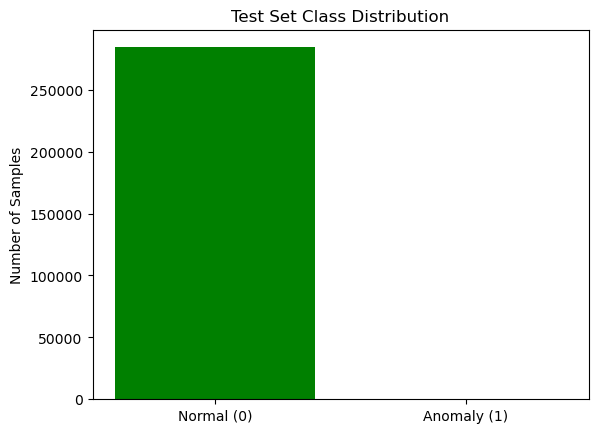

In [12]:
plt.bar(['Normal (0)', 'Anomaly (1)'], y.value_counts(), color=['green', 'red'])
plt.title("Test Set Class Distribution")
plt.ylabel("Number of Samples")
plt.show()

In [13]:
percent_anomaly = (y.value_counts()[1] / len(y)) * 100
print(f"Anomaly percentage: {percent_anomaly:.2f}%")

Anomaly percentage: 0.17%


In [14]:
#Added this section to balance test set for evaluation purpose
X_normal_sampled = X_train[y_train == 0].sample(n=492, random_state=42)
X_train_remaining = X_train.drop(X_normal_sampled.index)
y_train_remaining = y_train.drop(X_normal_sampled.index)

X_test_balanced = pd.concat([X_normal_sampled, X_test])
y_test_balanced = np.concatenate([np.zeros(492), np.ones(y_test.shape[0])])

# Convert y_test_balanced to a pandas Series with the same index as X_test_balanced
y_test_balanced = pd.Series(y_test_balanced, index=X_test_balanced.index)

X_train = X_train_remaining
y_train = y_train_remaining

X_test = X_test_balanced
y_test = y_test_balanced


print(y_test.value_counts())

0.0    492
1.0    492
dtype: int64


In [15]:
print("Total rows in X_test:", X_test.shape[0])  # Total rows in X_test after sampling
print("Total rows in X_train:", X_train.shape[0])  # Total rows in X_train after sampling
print("Total rows in X_train for normal instances (y == 0):", X_train[y_train == 0].shape[0]) 
print("Total rows in X_train for anomaly instances (y == 1):", X_train[y_train == 1].shape[0])

Total rows in X_test: 984
Total rows in X_train: 283823
Total rows in X_train for normal instances (y == 0): 283823
Total rows in X_train for anomaly instances (y == 1): 0


### Initializing Class and Parameters

In [19]:
#class ExplainAnomaliesUsingSHAP:
#    autoencoder = None
#    num_anomalies_to_explain = None
#    reconstruction_error_percent = None
#    shap_values_selection = None
#    counter = None

#    def __init__(self, num_anomalies_to_explain=100, reconstruction_error_percent=0.5, shap_values_selection='mean'):
#        self.num_anomalies_to_explain = num_anomalies_to_explain
#        self.reconstruction_error_percent = reconstruction_error_percent
#        self.shap_values_selection = shap_values_selection

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader, TensorDataset

In [103]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Sigmoid()  # Sigmoid for the output layer to get values in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [104]:
# L1 Regularization Term
def l1_regularization(model, lambda_l1=1e-5):
    l1_norm = 0
    for param in model.parameters():
        l1_norm += torch.sum(torch.abs(param))  # L1 regularization
    return lambda_l1 * l1_norm

In [101]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)  # Convert X_train to a tensor
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # Input and output are the same
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Training the Autoencoder

In [114]:
#Pytorch

# Training loop
start_time = time.time()
best_loss = float('inf')
patience_counter = 0

input_dim = X_train.shape[1]
epochs = 1000
learning_rate = 1e-3
patience = 5  # Early stopping patience

# Initialize model, optimizer, and loss function
model = Autoencoder(input_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed = model(data)
        
        # Compute the reconstruction loss (MSE)
        loss = criterion(reconstructed, data)
        
        # Apply L1 regularization
        l1_reg = l1_regularization(model)
        
        # Total loss: reconstruction loss + L1 regularization
        total_loss = loss + l1_reg
        
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()

    # Average loss for this epoch
    epoch_loss /= len(train_loader)
    
    # Early stopping logic
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")

Epoch [0/1000], Loss: 0.0028
Epoch [10/1000], Loss: 0.0017
Epoch [20/1000], Loss: 0.0017
Epoch [30/1000], Loss: 0.0017
Early stopping at epoch 39
Execution Time: 721.4448 seconds


In [16]:
start_time = time.time()

input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))

encoder = Dense(int(input_dim / 2), activation='relu', activity_regularizer=regularizers.l1(10e-7))(input_layer)
encoder = Dense(int(input_dim / 4), activation='relu', kernel_regularizer=regularizers.l2(10e-7))(encoder)

decoder = Dense(int(input_dim / 2), activation='relu', kernel_regularizer=regularizers.l2(10e-7))(encoder)
decoder = Dense(input_dim, activation='sigmoid', kernel_regularizer=regularizers.l2(10e-7))(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = autoencoder.fit(X_train, X_train, epochs=1000, batch_size=64, shuffle=True,
                 validation_split=0.1, verbose=2, callbacks=[earlystopper])

end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time

print(f"Execution Time: {execution_time:.4f} seconds")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072 (4.19 KB)

 Trainable params: 1,072 (4.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
3992/3992 - 10s - 2ms/step - loss: 0.0026 - mse: 0.0024 - val_loss: 0.0012 - val_mse: 0.0011
Epoch 2/1000
3992/3992 - 7s - 2ms/step - loss: 0.0011 - mse: 0.0010 - val_loss: 9.2540e-04 - val_mse: 8.4088e-04
Epoch 3/1000
3992/3992 - 7s - 2ms/step - loss: 8.9774e-04 - mse: 8.0746e-04 - val_loss: 8.1938e-04 - val_mse: 7.2700e-04
Epoch 4/1000
3992/3992 - 6s - 1ms/step - loss: 8.4445e-04 - mse: 7.5518e-04 - val_loss: 8.0799e-04 - val_mse: 7.2000e-04
Epoch 5/1000
3992/3992 - 7s - 2ms/step - loss: 8.3132e-04 - mse: 7.4579e-04 - val_loss: 8.1090e-04 - val_mse: 7.2516e-04
Epoch 6/1000
3992/3992 - 7s - 2ms/step - loss: 8.2355e-04 - mse: 7.4005e-04 - val_loss: 8.0112e-04 - val_mse: 7.1905e-04
Epoch 7/1000
3992/3992 - 7s - 2ms/step - loss: 8.1945e-04 - mse: 7.3691e-04 - val_loss: 7.9973e-04 - val_mse: 7.1757e-04
Epoch 8/1000
3992/3992 - 7s - 2ms/step - loss: 8.1718e-04 - mse: 7.3522e-04 - val_loss: 7.9325e-04 - val_mse: 7.1043e-04
Epoch 9/1000
3992/3992 - 7s - 2ms/step - loss: 8.1597e-

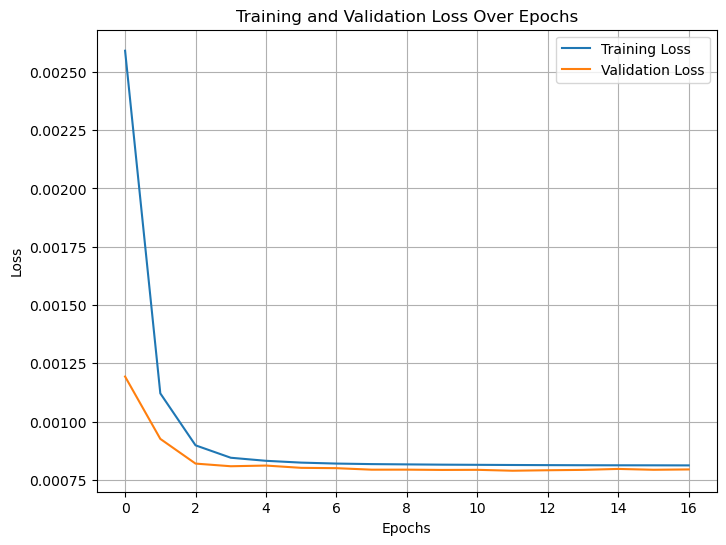

In [17]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate the autoencoder for anomaly detection.

In [18]:
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

train_recon_error = np.mean(np.square(X_train - X_train_pred), axis=1)
test_recon_error = np.mean(np.square(X_test - X_test_pred), axis=1)

threshold = np.percentile(train_recon_error, 95)
y_pred = [1 if e > threshold else 0 for e in test_recon_error]

8870/8870 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


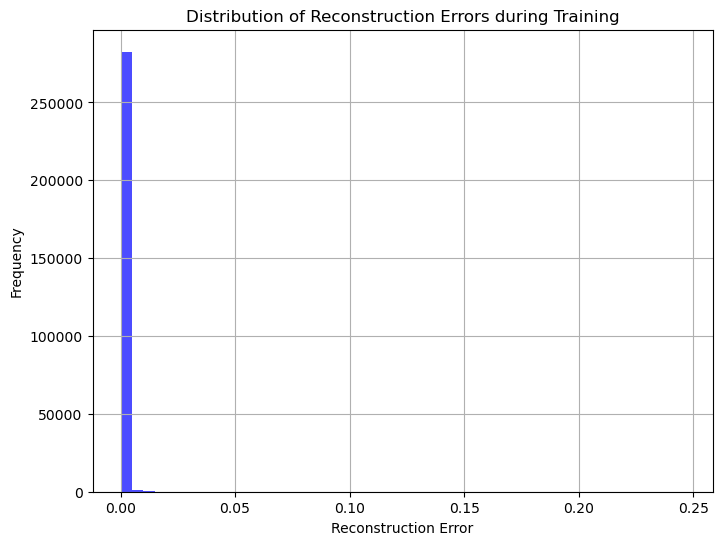

In [19]:
plt.figure(figsize=(8, 6))
plt.hist(train_recon_error, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Reconstruction Errors during Training')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


# Precision, Recall, F1-Score for anomaly detection
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print individual scores
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification report for a detailed overview
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[471  21]
 [ 60 432]]
Precision: 0.9536
Recall: 0.8780
F1-Score: 0.9143
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92       492
         1.0       0.95      0.88      0.91       492

    accuracy                           0.92       984
   macro avg       0.92      0.92      0.92       984
weighted avg       0.92      0.92      0.92       984



In [21]:
fpr, tpr, thresholds = roc_curve(y_test, test_recon_error)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

AUC: 0.9540


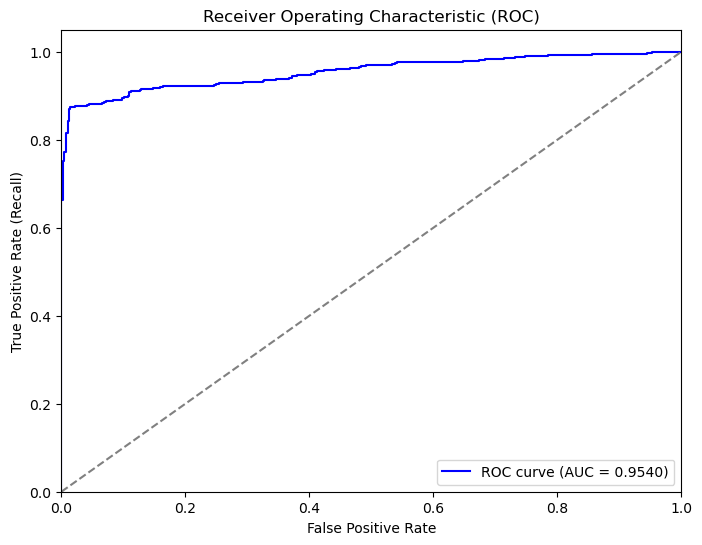

In [22]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

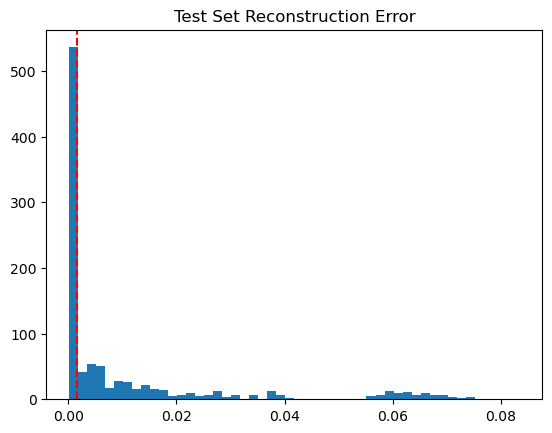

In [23]:
plt.hist(test_recon_error, bins=50)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Test Set Reconstruction Error")
plt.show()

### Getting Top Anomalies

In [24]:
# Get top 10 anomalies for explanation

#predictions = autoencoder.predict(X_test)
square_errors = np.power(X_test - X_test_pred, 2)
mse_series = pd.Series(np.mean(square_errors, axis=1))

most_anomal_trx = mse_series.sort_values(ascending=False)
columns = ["id", "mse_all_columns"]
columns.extend(["squared_error_" + x for x in list(X_test.columns)])

items = []
for x in most_anomal_trx.iteritems():
    item = [x[0], x[1]]
    item.extend(square_errors.loc[x[0]])
    items.append(item)

df_anomalies = pd.DataFrame(items, columns=columns)
df_anomalies.set_index('id', inplace=True)

top_anomalies_to_explain = df_anomalies.head(10).index  # Heden anomaly explain hiihee songoh

In [136]:
df_anomalies.head(10)

,mse_all_columns,squared_error_V1,squared_error_V2,squared_error_V3,squared_error_V4,squared_error_V5,squared_error_V6,squared_error_V7,squared_error_V8,squared_error_V9,...,squared_error_V20,squared_error_V21,squared_error_V22,squared_error_V23,squared_error_V24,squared_error_V25,squared_error_V26,squared_error_V27,squared_error_V28,squared_error_Amount
id,,,,,,,,,,,,,,,,,,,,,
154684,0.083149,0.232972,0.053885,0.244423,0.268095,0.016658,0.003658,0.070045,0.195024,0.243123,...,1.392293e-02,0.134706,0.147477,6.482682e-03,0.004867,0.006250,0.003666,0.010989,0.000076,1.228562e-05
154587,0.083143,0.226477,0.051067,0.227652,0.262943,0.014847,0.003403,0.063771,0.175276,0.248762,...,1.234128e-02,0.118902,0.152294,5.226031e-03,0.007013,0.006439,0.003149,0.009957,0.000014,1.224955e-05
154371,0.072532,0.190203,0.040301,0.204538,0.235051,0.012535,0.001655,0.051010,0.094602,0.175085,...,6.988891e-03,0.073511,0.074916,2.676257e-03,0.008294,0.001490,0.002320,0.008345,0.000084,1.160701e-05
42528,0.069970,0.005198,0.002945,0.019958,0.111753,0.002309,0.000568,0.002402,0.000708,0.066576,...,3.406857e-04,0.001292,0.000288,3.864403e-08,0.000231,0.000765,0.002102,0.001604,0.000410,9.456711e-05
150644,0.069857,0.003490,0.003512,0.029221,0.127936,0.001019,0.001799,0.002516,0.000499,0.051086,...,1.596512e-04,0.001018,0.000030,2.325573e-06,0.009642,0.000840,0.000023,0.001199,0.000428,3.122143e-07
150647,0.069803,0.003255,0.003230,0.028561,0.201235,0.001467,0.001166,0.004087,0.000960,0.046006,...,2.220034e-04,0.001423,0.001704,3.561990e-06,0.004064,0.000267,0.000006,0.000982,0.000307,1.004909e-05
150654,0.069292,0.003453,0.003798,0.035124,0.199469,0.001597,0.001527,0.004065,0.001104,0.051233,...,1.779779e-04,0.001322,0.000348,2.653653e-05,0.006866,0.001351,0.000008,0.000686,0.000260,1.229479e-05
150665,0.068356,0.012125,0.003146,0.034128,0.155540,0.003072,0.000764,0.003873,0.001957,0.051183,...,4.715001e-07,0.000975,0.000403,3.135365e-05,0.014925,0.001376,0.000012,0.000464,0.000018,2.165916e-05
8296,0.068090,0.000698,0.003962,0.040314,0.153532,0.000279,0.002132,0.002001,0.000244,0.061406,...,3.410964e-04,0.000583,0.001670,1.037949e-04,0.000659,0.013891,0.000303,0.001544,0.000549,1.219236e-05


In [133]:
df_anomalies.shape

(984, 30)

In [25]:
top_anomalies_to_explain

Int64Index([154684, 154587, 8296, 9035, 150644, 150647, 150654, 8615, 42528,
            150601],
           dtype='int64', name='id')

### Errors Data Frame per Record

In [40]:
def get_errors_df_per_record(record):
    prediction = autoencoder.predict(np.array([[record]])[0])[0]
    square_errors = np.power(record - prediction, 2)
    errors_df = pd.DataFrame({'col_name': square_errors.index, 'err': square_errors}).reset_index(drop=True)
    total_mse = np.mean(square_errors)
    errors_df.sort_values(by='err', ascending=False, inplace=True)
    return errors_df, total_mse

### Calculating Features with Highest Reconstruction Error

In [41]:
def get_num_features_with_highest_reconstruction_error(total_squared_error, errors_df):
    error = 0
    for num_of_features, index in enumerate(errors_df.index):
        error += errors_df.loc[index, 'err']
        #print("------------Error---------------")
        #print(error)
        if error >= 0.5 * total_squared_error:  # 0.5 is the default reconstruction_error_percent
            break
    return num_of_features + 1

### Predicting Feature Value

In [42]:
def func_predict_feature(record, counter):
    #print("Record in func_predict_feature")
    #print(record)
    #print("Counter in func_predict_feature")
    #print(counter)
    record_prediction = autoencoder.predict(record)[:, counter]
    
    #print("--------------Prediction of top anomaly record------------------")
    #print(record_prediction)
    return record_prediction

#X_test_pred = autoencoder.predict(X_test)

### Creating Background Set for SHAP

In [29]:
background_set = X_train.head(200)  # Get first 200 records (adjust the number as needed)
#background = X_train.sample(200, random_state=0)

### Getting SHAP Values for Features

In [43]:
def get_shap_values(df_top_err, record_to_explain, num_of_features): 
     
    shap_values_all_features = [[] for num in range(num_of_features)]
    
    for i in range(num_of_features):
        #print("---Orig counter---")
        counter = df_top_err.index[i]
        #print(counter)
        explainer = shap.KernelExplainer(lambda x: func_predict_feature(x, counter), background_set)
        shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
        #print("---Shap value---")
        #print(shap_values)
        shap_values_all_features[i] = shap_values
        #print("---shap_values_all_features", i, "---")
        #print(shap_values_all_features[i])

     
    shap_values_all_features = np.fabs(shap_values_all_features)
    #print("---shap_values_all_features---")
    #print(shap_values_all_features)

    return shap_values_all_features

### Getting Highest SHAP Values

In [31]:
def get_highest_shap_values(shap_values_df, shap_values_selection):

        all_explaining_features_df = pd.DataFrame()

        for i in range(shap_values_df.shape[0]):
            shap_values = shap_values_df.iloc[i]

            if shap_values_selection == 'mean':
                treshold_val = np.mean(shap_values)

            elif shap_values_selection == 'median':
                treshold_val = np.median(shap_values)

            elif shap_values_selection == 'constant':
                num_explaining_features = 5
                explaining_features = shap_values_df[i:i + 1].stack().nlargest(num_explaining_features)
                all_explaining_features_df = pd.concat([all_explaining_features_df, explaining_features], axis=0)
                continue

            else:
                raise ValueError('unknown SHAP value selection method')

            num_explaining_features = 0
            for j in range(len(shap_values)):
                if shap_values[j] > treshold_val:
                    num_explaining_features += 1
            explaining_features = shap_values_df[i:i + 1].stack().nlargest(num_explaining_features)
            all_explaining_features_df = pd.concat([all_explaining_features_df, explaining_features], axis=0)
        return all_explaining_features_df

### Set Explaining for Features

In [32]:
def set_explaining_features(df_top_err, highest_contributing_features, num_of_features, all_sets_explaining_features, record_idx):
    
    set_explaining_features = []

    for idx_explained_feature in range(num_of_features):
        feature_set = []

        # Iterate over SHAP values to find the highest contributing features
        for idx, row in highest_contributing_features.iterrows():
            if idx[0] == idx_explained_feature:
                feature_set.append((idx[1], row[0]))

        # Get the feature being explained from df_top_err
        explained_feature_index = df_top_err.index[idx_explained_feature]
        feature_set.insert(0, (X_train.columns[explained_feature_index], -1))

        # Append the feature set to the all_sets_explaining_features dictionary for the given record_idx
        if record_idx not in all_sets_explaining_features:
            all_sets_explaining_features[record_idx] = []

        all_sets_explaining_features[record_idx].append(feature_set)

    return all_sets_explaining_features

### Main Function

In [33]:
def main():
    all_sets_explaining_features = {}
    

    for record_idx in top_anomalies_to_explain[:3]:  # Process only the first 3 anomalies
        record_to_explain = X_test.loc[record_idx]
        
        # Get reconstruction errors and total MSE
        df_err, total_mse = get_errors_df_per_record(record_to_explain)
        
        print(df_err)
        print(total_mse)
        print(total_mse * df_err.shape[0])
        
        # Get the number of features contributing to reconstruction error
        num_of_features = get_num_features_with_highest_reconstruction_error(
            total_mse * df_err.shape[0], df_err
        )
        
        print(num_of_features)                
        
        # Get top 'num_of_features' by error
        df_top_err = df_err.head(num_of_features)
        
        print("df_top_err")
        print(df_top_err)
        print("record_to_explain")
        print(record_to_explain)
        
        
        # Get SHAP values for the top features
        shap_values_all_features = get_shap_values(df_top_err, record_to_explain, num_of_features)
        
        print("shap_values_all_features in main")
        print(shap_values_all_features)
        print(shap_values_all_features.shape)
        
        
        # Convert SHAP values to DataFrame
        shap_values_all_features = pd.DataFrame(
            data=shap_values_all_features, columns=X_train.columns
        )
        
        print("-----------------------------------")
        print(shap_values_all_features)
        
        # Get the features with the highest SHAP values
        highest_contributing_features = get_highest_shap_values(
            shap_values_all_features, shap_values_selection="mean"
        )
        
        print("highest_contributing_features")
        print(highest_contributing_features)
    
        
        # Update the dictionary with features explaining the record
        all_sets_explaining_features = set_explaining_features(
            df_top_err, highest_contributing_features, num_of_features, 
            all_sets_explaining_features, record_idx
        )
        
        print("all_sets_explaining_features")
        print(all_sets_explaining_features)
    
        # Ensure no duplicate features are added for each record
        final_set_features = set()
        final_set_items = []
        for item in sum(all_sets_explaining_features[record_idx], []):
            if item[0] not in final_set_features:
                final_set_features.add(item[0])
                final_set_items.append(item)
                
                
        print("final_set_items")
        print(final_set_items)

    
        # Update the dictionary with unique features
        all_sets_explaining_features[record_idx] = final_set_items
        
        print("all_sets_explaining_features[record_idx]", record_idx)
        print(all_sets_explaining_features[record_idx])


    print("Completed processing the top 3 anomalies.")
    print(all_sets_explaining_features)
    
    for record_idx, feature_list in all_sets_explaining_features.items():
        print(f"🧾 Record Index: {record_idx}")
        print("-" * 60)
        for feature, contribution in feature_list:
            print(f"Feature: {feature:<30} | Contribution: {contribution:+.4f}")
        print("-" * 60 + "\n")
    


if __name__ == "__main__":
    
    start_time = time.time()
    main()
    end_time = time.time()

    # Calculate execution time
    execution_time = end_time - start_time

    print(f"Execution Time: {execution_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
   col_name       err
3        V4  0.263662
9       V10  0.261217
0        V1  0.237133
2        V3  0.236832
8        V9  0.214414
7        V8  0.193754
21      V22  0.147767
16      V17  0.143066
17      V18  0.139222
20      V21  0.135310
11      V12  0.116310
6        V7  0.070228
1        V2  0.055155
10      V11  0.045374
12      V13  0.033065
15      V16  0.031206
23      V24  0.029592
4        V5  0.016271
19      V20  0.013640
26      V27  0.010747
18      V19  0.008549
24      V25  0.007664
22      V23  0.006714
5        V6  0.004357
13      V14  0.000638
14      V15  0.000351
27      V28  0.000073
25      V26  0.000028
28   Amount  0.000012
0.08352936106118226
2.4223514707742857
------------Error---------------
0.2636621647449873
------------Error---------------
0.5248789104844229
------------Error---------------
0.7620115331000747
------------Error---------------
0.9988440098627909
------------Error---------------
1.213257762136526
5
df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
--------------Prediction of top anomaly record------------------
[0.5110937]
Record in func_predict_feature
[[4.70559504e-01 7.66490419e-01 8.81364903e-01 ... 4.18976135e-01
  3.12696634e-01 5.82379309e-03]
 [4.70559504e-01 7.70066651e-01 8.40298490e-01 ... 4.16345145e-01
  3.13422663e-01 1.04705276e-04]
 [4.70559504e-01 7.53117667e-01 8.68140819e-01 ... 4.15489266e-01
  3.11911316e-01 1.47389219e-02]
 ...
 [4.70559504e-01 1.00000000e+00 3.54712099e-01 ... 3.11627954e-01
  3.13571188e-01 6.20057639e-04]
 [4.70559504e-01 1.00000000e+00 3.54712099e-01 ... 3.11627954e-01
  3.09792609e-01 3.89238944e-04]
 [4.70559504e-01 1.00000000e+00 3.54712099e-01 ... 3.11627954e-01
  3.15382939e-01 1.50635472e-04]]
Counter in func_predict_feature
9
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
--------------Prediction of top anomaly record------------------
[0.51124334 0.5110409  0.51059926 ... 0.51144505 0.5114733  0.51128846]
---Shap value---
[ 0.          0.    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
--------------Prediction of top anomaly record------------------
[0.84136647]
Record in func_predict_feature
[[4.70559504e-01 7.66490419e-01 8.81364903e-01 ... 4.18976135e-01
  3.12696634e-01 5.82379309e-03]
 [4.70559504e-01 7.70066651e-01 8.40298490e-01 ... 4.16345145e-01
  3.13422663e-01 1.04705276e-04]
 [4.70559504e-01 7.53117667e-01 8.68140819e-01 ... 4.15489266e-01
  3.11911316e-01 1.47389219e-02]
 ...
 [9.81284383e-01 1.00000000e+00 3.54712099e-01 ... 3.11627954e-01
  3.13571188e-01 6.20057639e-04]
 [9.41179458e-01 1.00000000e+00 3.54712099e-01 ... 3.11627954e-01
  3.09792609e-01 3.89238944e-04]
 [9.51586348e-01 1.00000000e+00 3.54712099e-01 ... 3.11627954e-01
  3.15382939e-01 1.50635472e-04]]
Counter in func_predict_feature
2
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
--------------Prediction of top anomaly record------------------
[0.8385378  0.83840406 0.8376411  ... 0.8416985  0.84164435 0.8411014 ]
---Shap value---
[ 0.          0.000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
   col_name       err
9       V10  0.257501
3        V4  0.253680
0        V1  0.229548
2        V3  0.220949
8        V9  0.219951
7        V8  0.174824
17      V18  0.151605
21      V22  0.148922
16      V17  0.141732
11      V12  0.128847
20      V21  0.119833
6        V7  0.063764
1        V2  0.052518
10      V11  0.047463
15      V16  0.042396
12      V13  0.034160
23      V24  0.023201
4        V5  0.014625
19      V20  0.012125
26      V27  0.009692
24      V25  0.007420
18      V19  0.006245
22      V23  0.005455
5        V6  0.003776
14      V15  0.001304
13      V14  0.000046
25      V26  0.000037
28   Amount  0.000012
27      V28  0.000010
0.08178069657629311
2.3716402007125
------------Error---------------
0.25750143116646107
------------Error---------------
0.511181743497817
------------Error---------------
0.74072929972679
------------Error---------------
0.9616786636049589
------------Error---------------
1.1816292476287225
--------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
--------------Prediction of top anomaly record------------------
[0.268574]
Record in func_predict_feature
[[4.78275398e-01 7.66490419e-01 8.81364903e-01 ... 4.18976135e-01
  3.12696634e-01 5.82379309e-03]
 [4.78275398e-01 7.70066651e-01 8.40298490e-01 ... 4.16345145e-01
  3.13422663e-01 1.04705276e-04]
 [4.78275398e-01 7.53117667e-01 8.68140819e-01 ... 4.15489266e-01
  3.11911316e-01 1.47389219e-02]
 ...
 [4.78275398e-01 9.93769078e-01 3.71771602e-01 ... 4.17360480e-01
  3.13571188e-01 0.00000000e+00]
 [4.78275398e-01 9.93769078e-01 3.71771602e-01 ... 4.07948176e-01
  3.09792609e-01 0.00000000e+00]
 [4.78275398e-01 9.93769078e-01 3.71771602e-01 ... 4.21814957e-01
  3.15382939e-01 0.00000000e+00]]
Counter in func_predict_feature
3
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
--------------Prediction of top anomaly record------------------
[0.24679388 0.24698006 0.23946351 ... 0.26486263 0.26577026 0.264536  ]
---Shap value---
[ 0.          0.00072

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
--------------Prediction of top anomaly record------------------
[0.8418241]
Record in func_predict_feature
[[4.78275398e-01 7.66490419e-01 8.81364903e-01 ... 4.18976135e-01
  3.12696634e-01 5.82379309e-03]
 [4.78275398e-01 7.70066651e-01 8.40298490e-01 ... 4.16345145e-01
  3.13422663e-01 1.04705276e-04]
 [4.78275398e-01 7.53117667e-01 8.68140819e-01 ... 4.15489266e-01
  3.11911316e-01 1.47389219e-02]
 ...
 [4.78275398e-01 9.93769078e-01 3.71771602e-01 ... 3.16694867e-01
  3.09393773e-01 0.00000000e+00]
 [4.78275398e-01 9.93769078e-01 3.71771602e-01 ... 3.16694867e-01
  3.09393773e-01 0.00000000e+00]
 [4.78275398e-01 9.93769078e-01 3.71771602e-01 ... 3.16694867e-01
  3.09393773e-01 0.00000000e+00]]
Counter in func_predict_feature
2
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
--------------Prediction of top anomaly record------------------
[0.8385384  0.83840466 0.83764017 ... 0.8406374  0.8406136  0.84056354]
---Shap value---
[ 0.          0.0002

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
--------------Prediction of top anomaly record------------------
[0.78529364]
Record in func_predict_feature
[[4.78275398e-01 7.66490419e-01 8.81364903e-01 ... 4.18976135e-01
  3.12696634e-01 5.82379309e-03]
 [4.78275398e-01 7.70066651e-01 8.40298490e-01 ... 4.16345145e-01
  3.13422663e-01 1.04705276e-04]
 [4.78275398e-01 7.53117667e-01 8.68140819e-01 ... 4.15489266e-01
  3.11911316e-01 1.47389219e-02]
 ...
 [9.81284383e-01 7.59926146e-01 8.54236661e-01 ... 4.17360480e-01
  3.09393773e-01 6.20057639e-04]
 [9.41179458e-01 7.80573734e-01 8.58332731e-01 ... 4.07948176e-01
  3.09393773e-01 3.89238944e-04]
 [9.51586348e-01 7.78384039e-01 8.58318150e-01 ... 4.21814957e-01
  3.09393773e-01 1.50635472e-04]]
Counter in func_predict_feature
7
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
--------------Prediction of top anomaly record------------------
[0.7851486  0.7854382  0.7853528  ... 0.78509545 0.78509164 0.78510016]
---Shap value---
[ 0.          0.   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
   col_name       err
10      V11  0.486634
11      V12  0.440094
13      V14  0.421539
16      V17  0.202679
3        V4  0.158399
17      V18  0.142923
15      V16  0.105353
9       V10  0.071722
8        V9  0.043083
2        V3  0.037338
12      V13  0.026114
23      V24  0.023781
24      V25  0.009053
1        V2  0.004168
6        V7  0.002254
26      V27  0.001597
0        V1  0.001261
18      V19  0.001256
5        V6  0.000816
20      V21  0.000686
27      V28  0.000509
7        V8  0.000462
19      V20  0.000211
21      V22  0.000204
4        V5  0.000125
22      V23  0.000080
25      V26  0.000020
28   Amount  0.000012
14      V15  0.000005
0.07525437725172869
2.182376940300132
------------Error---------------
0.48663400272055046
------------Error---------------
0.9267278919350272
------------Error---------------
1.348267270775676
3
df_top_err
   col_name       err
10      V11  0.486634
11      V12  0.440094
13      V14  0.421539
record_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
--------------Prediction of top anomaly record------------------
[0.6978661]
Record in func_predict_feature
[[9.22184336e-01 7.66490419e-01 8.81364903e-01 ... 4.18976135e-01
  3.12696634e-01 5.82379309e-03]
 [9.22184336e-01 7.70066651e-01 8.40298490e-01 ... 4.16345145e-01
  3.13422663e-01 1.04705276e-04]
 [9.22184336e-01 7.53117667e-01 8.68140819e-01 ... 4.15489266e-01
  3.11911316e-01 1.47389219e-02]
 ...
 [9.22184336e-01 8.30288206e-01 8.54236661e-01 ... 4.17360480e-01
  3.13571188e-01 3.89238944e-05]
 [9.22184336e-01 8.30288206e-01 8.58332731e-01 ... 4.07948176e-01
  3.09792609e-01 3.89238944e-05]
 [9.22184336e-01 8.30288206e-01 8.58318150e-01 ... 4.21814957e-01
  3.15382939e-01 3.89238944e-05]]
Counter in func_predict_feature
11
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
--------------Prediction of top anomaly record------------------
[0.70400417 0.70066434 0.6997533  ... 0.700353   0.70030844 0.69940346]
---Shap value---
[ 0.00000000e+00  0

### Ablation test

In [38]:
def ablation_test(record, model, top_features):
    modified_record = record.copy()
    modified_record[top_features] = 0  # zero out top features (you can try np.nan too)
    prediction = model.predict(np.array([modified_record]))[0]
    error = np.mean(np.power(record - prediction, 2))
    return error

In [ ]:
def main():
    all_sets_explaining_features = {}
    

    for record_idx in top_anomalies_to_explain[:3]:  # Process only the first 3 anomalies
        record_to_explain = X_test.loc[record_idx]
        
        # Get reconstruction errors and total MSE
        df_err, total_mse = get_errors_df_per_record(record_to_explain)
        
        #print(df_err)
        #print(total_mse)
        #print(total_mse * df_err.shape[0])
        
        # Get the number of features contributing to reconstruction error
        num_of_features = get_num_features_with_highest_reconstruction_error(
            total_mse * df_err.shape[0], df_err
        )
        
        #print(num_of_features)                
        
        # Get top 'num_of_features' by error
        df_top_err = df_err.head(num_of_features)
        
        #print("df_top_err")
        #print(df_top_err)
        #print("record_to_explain")
        #print(record_to_explain)
        
        
        # Get SHAP values for the top features
        shap_values_all_features = get_shap_values(df_top_err, record_to_explain, num_of_features)
        
        #print("shap_values_all_features in main")
        #print(shap_values_all_features)
        #print(shap_values_all_features.shape)
        
        
        # Convert SHAP values to DataFrame
        shap_values_all_features = pd.DataFrame(
            data=shap_values_all_features, columns=X_train.columns
        )
        
        #print("-----------------------------------")
        #print(shap_values_all_features)
        
        # Get the features with the highest SHAP values
        highest_contributing_features = get_highest_shap_values(
            shap_values_all_features, shap_values_selection="mean"
        )
        
        #print("highest_contributing_features")
        #print(highest_contributing_features)
    
        
        # Update the dictionary with features explaining the record
        all_sets_explaining_features = set_explaining_features(
            df_top_err, highest_contributing_features, num_of_features, 
            all_sets_explaining_features, record_idx
        )
        
        #print("all_sets_explaining_features")
        #print(all_sets_explaining_features)
    
        # Ensure no duplicate features are added for each record
        final_set_features = set()
        final_set_items = []
        for item in sum(all_sets_explaining_features[record_idx], []):
            if item[0] not in final_set_features:
                final_set_features.add(item[0])
                final_set_items.append(item)
                
                
        #print("final_set_items")
        #print(final_set_items)

    
        # Update the dictionary with unique features
        all_sets_explaining_features[record_idx] = final_set_items
        
        # Print original explanation and MSE before ablation
        print(f"\nExplanation for Record {record_idx}:")
        print(f"MSE before ablation: {total_mse:.4f}")
        print("-" * 50)
        for record_idx, feature_list in all_sets_explaining_features.items():
            print(f"🧾 Record Index: {record_idx}")
            print("-" * 60)
            for feature, contribution in feature_list:
                print(f"Feature: {feature:<30} | Contribution: {contribution:+.4f}")
            print("-" * 60 + "\n")
        
        print("\n Ablation Test Results:")
        for n in range(1, num_of_features + 1):
            top_features = df_top_err['col_name'].values[:n]
            ablated_mse = ablation_test(record_to_explain, autoencoder, top_features)
            print(f"\nZeroed Feature(s) - {list(top_features)}: Ablated MSE = {ablated_mse:.4f}")

            modified_record = record_to_explain.copy()
            modified_record[top_features] = 0

            # SHAP explanation after ablation
            shap_values_ablation = get_shap_values(df_top_err, modified_record, num_of_features)
            shap_df_ablation = pd.DataFrame(data=shap_values_ablation, columns=X_train.columns)
            top_contributing_ablation = get_highest_shap_values(shap_df_ablation, shap_values_selection="mean")

            print("Explanation for modified record after ablation (SHAP):")
            for record_idx, feature_list in all_sets_explaining_features.items():
                print(f"🧾 Record Index: {record_idx}")
                print("-" * 60)
                for feature, contribution in feature_list:
                    print(f"Feature: {feature:<30} | Contribution: {contribution:+.4f}")
                print("-" * 60 + "\n")
        print("-" * 50)


    print("Completed processing the top 3 anomalies.")
    print(all_sets_explaining_features)
    
    for record_idx, feature_list in all_sets_explaining_features.items():
        print(f"🧾 Record Index: {record_idx}")
        print("-" * 60)
        for feature, contribution in feature_list:
            print(f"Feature: {feature:<30} | SHAP Contribution: {contribution:+.4f}")
        print("-" * 60 + "\n")
    


if __name__ == "__main__":
    
    start_time = time.time()
    main()
    end_time = time.time()

    # Calculate execution time
    execution_time = end_time - start_time

    print(f"Execution Time: {execution_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step

 Explanation for Record 154684:
MSE before ablation: 0.0835
--------------------------------------------------
🧾 Record Index: 154684
------------------------------------------------------------
Feature: V4                             | Contribution: -1.0000
Feature: V15                            | Contribution: +0.0118
Feature: V7                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Zeroed Feature(s) - ['V4', 'V10', 'V1', 'V3']: Ablated MSE = 0.0845
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
Explanation for modified record after ablation (SHAP):
🧾 Record Index: 154684
------------------------------------------------------------
Feature: V4                             | Contribution: -1.0000
Feature: V15                            | Contribution: +0.0118
Feature: V7     

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Zeroed Feature(s) - ['V10']: Ablated MSE = 0.0818
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
Explanation for modified record after ablation (SHAP):
🧾 Record Index: 154684
------------------------------------------------------------
Feature: V4                             

13163/13163 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step
Explanation for modified record after ablation (SHAP):
🧾 Record Index: 154684
------------------------------------------------------------
Feature: V4                             | Contribution: -1.0000
Feature: V15                            | Contribution: +0.0118
Feature: V7                             | Contribution: +0.0027
Feature: V19                            | Contribution: +0.0019
Feature: V11                            | Contribution: +0.0014
Feature: V3                             | Contribution: +0.0013
Feature: V8                             | Contribution: +0.0010
Feature: V2                             | Contribution: +0.0009
Feature: V10                            | Contribution: -1.0000
Feature: V13                            | Contribution: +0.0001
Feature: V1                             | Contributio

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Zeroed Feature(s) - ['V10', 'V4', 'V1', 'V3', 'V9', 'V8']: Ablated MSE = 0.0830
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13163/13163 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Explanation for modified record after ablation (SHAP):
🧾 Record Index: 154684
------------------------------------------------------------
Feature: V